# 利用核技巧分类非线性数据集
- 核技巧就是利用核函数将输入空间映射到更高维的特征空间，从而使非线性数据集变得线性可分
- 不同的核函数适用于不同分布的非线性数据集
- 这里使用“径向基函数”作为核函数，适用于处理圆环分布的数据集
- 整体逻辑与SMOpro一致，差别只在于用K(x,xi)替换了X,Xi内积

## 1. 模型

In [20]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"

#设置出图显示中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 辅助函数1

In [2]:
def loadDataSet(filename):
    #filename是待读取文件的文件名或路径+文件名
    dataMat=[];labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        lineArr=line.strip().split("\t")
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def randPickj(i,m):
    #i是alphai的i值，整数; m是alpha个数; j不能等于i
    j=i
    while j==i:
        j=int(np.random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    if aj<L:
        aj=L
    return aj

### 辅助函数2：核转换函数

In [47]:
# X为数据集特征矩阵，A为X[i,:]
# kTup为元组类型，第一个参数表示所用核函数类型，第二个参数表示径向基函数对应的到达率(大小与支持向量对分离超平面的影响程度正相关)
def kernelTrans(X,A,kTup):
    m,n=X.shape
    K=np.mat(np.zeros((m,1)))
    if kTup[0]=="lin": #核函数类型为 线性函数
        K=X*A.T
    elif kTup[0]=="rbf": #核函数为 径向基函数
        for j in range(m): #遍历每个样本
            deltaRow=X[j,:]-A #Xj-Xi
            K[j]=deltaRow*deltaRow.T #||Xj-Xi||**2
        K=np.exp(K/-kTup[1]**2) #径向基函数公式
    else:
        raise NameError("Kernel not recognized")
    return K

In [43]:
#这里构造一个对象，目的是将此对象作为一个数据结构来使用
class optStruct:
    def __init__(self,data,label,C,toler,kTup):
        #全局变量
        self.X=data
        self.labelMatrix=label
        self.C=C
        self.toler=toler
        self.m=data.shape[0] #m为样本数
        
        #初始化alpha矩阵、b、Es矩阵
        self.alphas=np.mat(np.zeros((self.m,1)))
        self.Es=np.mat(np.zeros((self.m,2))) #缓存误差，两列，第一列表示当前Ei是否有效，第二列表示当前的Ei值
        self.b=0
        
        #核技巧增加项，初始化K矩阵(K矩阵用于存放K(xi,xj)，维度为m*m)
        self.K=np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i]=kernelTrans(self.X,self.X[i,:],kTup)
    
def calcEk(oS,k):
    gxk=float(np.multiply(oS.alphas,oS.labelMatrix).transpose()*oS.K[:,k]+oS.b)
    Ek=gxk-float(oS.labelMatrix[k])
    return Ek
    
#选择相较ai具有最大步长(即Ei-Ej)的aj的函数
def selectJ(oS,i,Ei):
    maxK=-1;maxDeltaE=0;Ej=0 #DeltaE表示Ei-Ej,k表示DeltaE最大的样本点索引值，最终会将Ek赋值给Ej
    oS.Es[i]=[1,Ei] #使Es矩阵第i位有效
    validEsList=np.nonzero(oS.Es[:,0].A)[0] #将Es矩阵中有效的Ei对应的索引值选出来，作为挑选j的池子
        
    if len(validEsList)>1:
        for k in validEsList:
            if k==i:
                continue
            Ek=calcEk(oS,k)
            deltaE=abs(Ei-Ek)
            if deltaE>maxDeltaE:
                maxDeltaE=deltaE;maxK=k;Ej=Ek
        return maxK,Ej
    else: #若validEsList只有一个Ei有效(初次循环)，则随机选取一个j
        j=randPickj(i,oS.m)
        Ej=calcEk(oS,j)
    return j,Ej
    
def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.Es[k]=[1,Ek]

### 内循环

In [49]:
def innerL(i,oS):
    Ei=calcEk(oS,i)
    
    #判断Ei是否是违反KKT条件超过toler的点，若是再继续挑选j
    if (oS.labelMatrix[i]*Ei<-oS.toler and oS.alphas[i]<oS.C) or (oS.labelMatrix[i]*Ei>oS.toler and oS.alphas[i]>0):
        j,Ej=selectJ(oS,i,Ei)
        alphaIold=oS.alphas[i].copy();alphaJold=oS.alphas[j].copy()
        
        #计算L，H
        if oS.labelMatrix[i]!=oS.labelMatrix[j]:
            L=max(0,oS.alphas[j]-oS.alphas[i]) #这里alpha[i]仍然等于alphaIold
            H=min(oS.C,oS.C+oS.alphas[j]-oS.alphas[i])         
        else:
            L=max(0,oS.alphas[j]+oS.alphas[i]-oS.C)
            H=min(oS.C,oS.alphas[j]+oS.alphas[i])
        if L==H:
            print ("L==H")
            return 0 #第一个跳出条件(跳出本次内循环，遍历下一个alpha进行更新)
        
        #计算eta
        eta=oS.K[i,i]+oS.K[j,j]-2.0*oS.K[i,j]
        if eta==0:
            print ("eta=0")
            return 0 #第二个跳出条件(因为eta=0不好处理，且出现情况较少，因此这里咱不处理，直接跳出)
                    
        #根据统计学习方法中的结果公式得到alphaj的解析解，并更新Ej值
        oS.alphas[j]=oS.alphas[j]+oS.labelMatrix[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j) #更新Ej值
        
        #检验alphaj与alphaJold是否有足够大的改变，若改变不够大，说明与alpha旧值没有什么差异，跳出本次内循环
        if abs(oS.alphas[j]-alphaJold)<0.00001:
            print ("j not moving enough")
            return 0 #第三个跳出条件
                    
        #约束条件让我们可以根据alphaJ求出alphaI
        oS.alphas[i]=oS.alphas[i]+oS.labelMatrix[i]*oS.labelMatrix[j]*(alphaJold-oS.alphas[j])
        updateEk(oS,i) #更新Ei值
        
        #更新b值,根据alpha是否在0～C决定更新的b值
        b1=-Ei-oS.labelMatrix[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i]\
        -oS.labelMatrix[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]+oS.b
                
        b2=-Ej-oS.labelMatrix[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]\
        -oS.labelMatrix[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]+oS.b
                
        #若ai或aj在(0,C)之间，则取b=bi或b=bj，若ai aj都不在(0,C)之间，取均值
        if oS.alphas[i]>0 and oS.alphas[i]<oS.C:
            oS.b=b1
        elif oS.alphas[j]>0 and oS.alphas[j]<oS.C:
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        return 1 #若执行到这里都没有return0跳出，说明已经完成了一个alpha对的更新，返回一个1
    
    else:
        return 0 #若ai不足够违反KKT条件，则return0跳出本次内循环

### 外循环

In [41]:
def SMOpro(data,label,C,toler,maxIter,kTup):
    oS=optStruct(np.mat(data),np.mat(label).transpose(),C,toler,kTup)
    iter=0;entireSet=True;alphaPairsChanged=0
    
    #当迭代次数达到上限(这里的迭代次数只要完成一次循环遍历就+1，不论该次循环遍历是否修改了alpha对)，或全集再无可修改的alpha对时，循环停止，计算完成
    while (iter<maxIter) and (entireSet or alphaPairsChanged>0):
        alphaPairsChanged=0
        if entireSet: #全集遍历
            for i in range(oS.m):
                alphaPairsChanged+=innerL(i,oS)
                print ("fullset, iter:%d i:%d, pairsChanged: %d" %(iter,i,alphaPairsChanged))
            iter+=1 #这里的迭代次数只要完成一次循环遍历就+1，不论该次循环遍历是否修改了alpha对
        
        else: #边界遍历
            boundIs=np.nonzero((oS.alphas.A>0)*(oS.alphas.A<oS.C))[0] #选择0<alpha<C的样本点的索引值(即边界点)
            for i in boundIs:
                alphaPairsChanged+=innerL(i,oS)
                print ("bound, iter:%d i:%d, pairsChanged: %d" %(iter,i,alphaPairsChanged))
            iter+=1
            
        #控制遍历往返于全集遍历和边界遍历
        if entireSet:
            entireSet=False #若本轮是全集遍历，则下一轮进入边界遍历(下一轮while条件中的entire是False)
        elif alphaPairsChanged==0:
            entireSet=True  #若本轮是边界遍历，且本轮遍历未修改任何alpha对，则下一轮进入全集遍历
        print ("iteration number: %d" %iter)
    return oS.b,oS.alphas

### 绘制函数

In [118]:
"""
绘制样本数据以及决策边界
思路：
1. 将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
2. 根据坐标集合，分别绘制两个类别样本的散点图
3. 绘制支持向量，象征非线性数据集的分离超平面位置
"""
def plotBestFit(svInd,filename):
    dataMat,labelMat=loadDataSet(filename) #加载样本特征、样本类别
    dataArr=np.array(dataMat)
    n=dataArr.shape[0] #n个样本
    xcord1=[];ycord1=[]
    xcord2=[];ycord2=[] #两个类别的样本的xy坐标值，x对应x1,y对应x2
    xcord1SV=[];ycord1SV=[] #1类的支持向量样本点坐标值
    xcord2SV=[];ycord2SV=[] #2类的支持向量样本点坐标值

    #将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
    for i in range(n):
        if (int(labelMat[i])==1) and (i in svInd): #第i个样本是1类且是支持向量点
            xcord1SV.append(dataArr[i,0]) #第i个样本的x1值
            ycord1SV.append(dataArr[i,1]) #第i个样本的x2值
        elif (int(labelMat[i])==1) and (i not in svInd): #第i个样本是1类且不是支持向量点
            xcord1.append(dataArr[i,0]) 
            ycord1.append(dataArr[i,1]) 
        elif (int(labelMat[i])==-1) and (i in svInd): #第i个样本是2类且是支持向量点
            xcord2SV.append(dataArr[i,0]) 
            ycord2SV.append(dataArr[i,1]) 
        else:
            xcord2.append(dataArr[i,0]) 
            ycord2.append(dataArr[i,1]) 
    
    #绘制两类样本的散点图
    fig=plt.figure(figsize=(12,8))
    plt.scatter(xcord1,ycord1,c="red",s=50,label="label=1")
    plt.scatter(xcord2,ycord2,c="blue",s=50,label="label=-1") #继续在原图上作图
    plt.scatter(xcord1SV,ycord1SV,c="darkorange",edgecolor="black",s=80,label="support vector")
    plt.scatter(xcord2SV,ycord2SV,c="green",edgecolor="black",s=80,label="support vector")

## 2. 测试
- 用两个圆环分布的数据集测试 利用了核技巧的SMO算法
- 数据集分布如下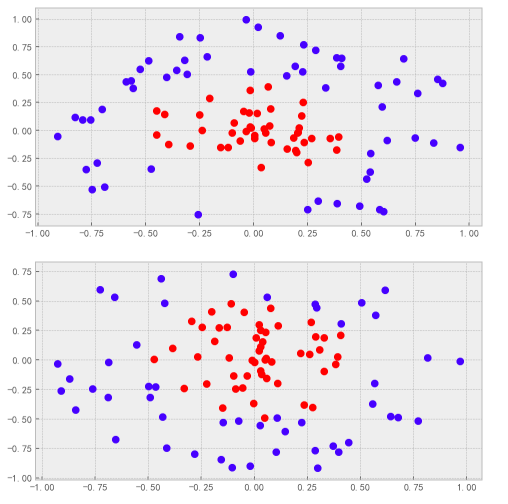

### 参数训练函数
- 训练参数
- 找到支持向量
- 计算分类误差

In [96]:
def testRBF(C,toler,maxIter,kTup):
    #训练参数
    data,label=loadDataSet("testSetRBF.txt")
    b,alphas=SMOpro(data,label,C,toler,maxIter,kTup)
    print (b,"\n",alphas[alphas>0])

    #找到支持向量
    dataMat=np.mat(data);labelMat=np.mat(label).transpose()
    svInd=np.nonzero(alphas.A>0)[0] #返回alpha>0的点的索引(即，支持向量点位置)
    svs=dataMat[svInd];labelSV=labelMat[svInd] #支持向量样本点特征和类型
    print ("There are %d Support Vectors" %svs.shape[0])
    
    #模型对于训练集的预测误差
    m,n=dataMat.shape;errorCount=0
    for i in range(m):
        kernelEval=kernelTrans(svs,dataMat[i,:],kTup) #只映射支持向量到特征空间
        predict=kernelEval.T*np.multiply(labelSV,alphas[svInd])+b #wiX+b
        if np.sign(predict)!=np.sign(label[i]): #sign(x)为判别函数，X>0输出1，否则输出-1
            errorCount+=1
    print ("The training error rate is {0}%".format(float(errorCount)/m))
    
    #模型对于测试集的预测误差
    data2,label2=loadDataSet("testSetRBF2.txt")
    dataMat2=np.mat(data2);labelMat2=np.mat(label2).transpose()
    svInd2=np.nonzero(alphas.A>0)[0] #返回alpha>0的点的索引(即，支持向量点位置)
    svs2=dataMat2[svInd2];labelSV2=labelMat2[svInd2] #支持向量样本点特征和类型
    print ("There are %d Support Vectors" %svs2.shape[0])
    
    m2,n2=dataMat2.shape;errorCount2=0
    for i in range(m2):
        kernelEval2=kernelTrans(svs2,dataMat2[i,:],kTup) #只映射支持向量到特征空间
        predict2=kernelEval2.T*np.multiply(labelSV2,alphas[svInd2])+b #wiX+b
        if np.sign(predict2)!=np.sign(label2[i]): #sign(x)为判别函数，X>0输出1，否则输出-1
            errorCount2+=1
    print ("The training error rate is {0}%".format(100.0*float(errorCount2)/m2))
    return b,alphas,svInd,svInd2

### 训练&绘图

In [129]:
b,alphas,svInd,svInd2=testRBF(20,0.001,1000,("rbf",0.4))

L==H
fullset, iter:0 i:0, pairsChanged: 0
fullset, iter:0 i:1, pairsChanged: 1
fullset, iter:0 i:2, pairsChanged: 2
fullset, iter:0 i:3, pairsChanged: 3
fullset, iter:0 i:4, pairsChanged: 4
fullset, iter:0 i:5, pairsChanged: 5
fullset, iter:0 i:6, pairsChanged: 6
fullset, iter:0 i:7, pairsChanged: 6
fullset, iter:0 i:8, pairsChanged: 6
fullset, iter:0 i:9, pairsChanged: 7
fullset, iter:0 i:10, pairsChanged: 8
fullset, iter:0 i:11, pairsChanged: 9
fullset, iter:0 i:12, pairsChanged: 9
L==H
fullset, iter:0 i:13, pairsChanged: 9
L==H
fullset, iter:0 i:14, pairsChanged: 9
fullset, iter:0 i:15, pairsChanged: 10
fullset, iter:0 i:16, pairsChanged: 10
fullset, iter:0 i:17, pairsChanged: 11
fullset, iter:0 i:18, pairsChanged: 12
L==H
fullset, iter:0 i:19, pairsChanged: 12
fullset, iter:0 i:20, pairsChanged: 12
fullset, iter:0 i:21, pairsChanged: 13
fullset, iter:0 i:22, pairsChanged: 13
L==H
fullset, iter:0 i:23, pairsChanged: 13
fullset, iter:0 i:24, pairsChanged: 14
fullset, iter:0 i:25, pai

The training error rate is 0.01%
There are 26 Support Vectors
The training error rate is 8.0%


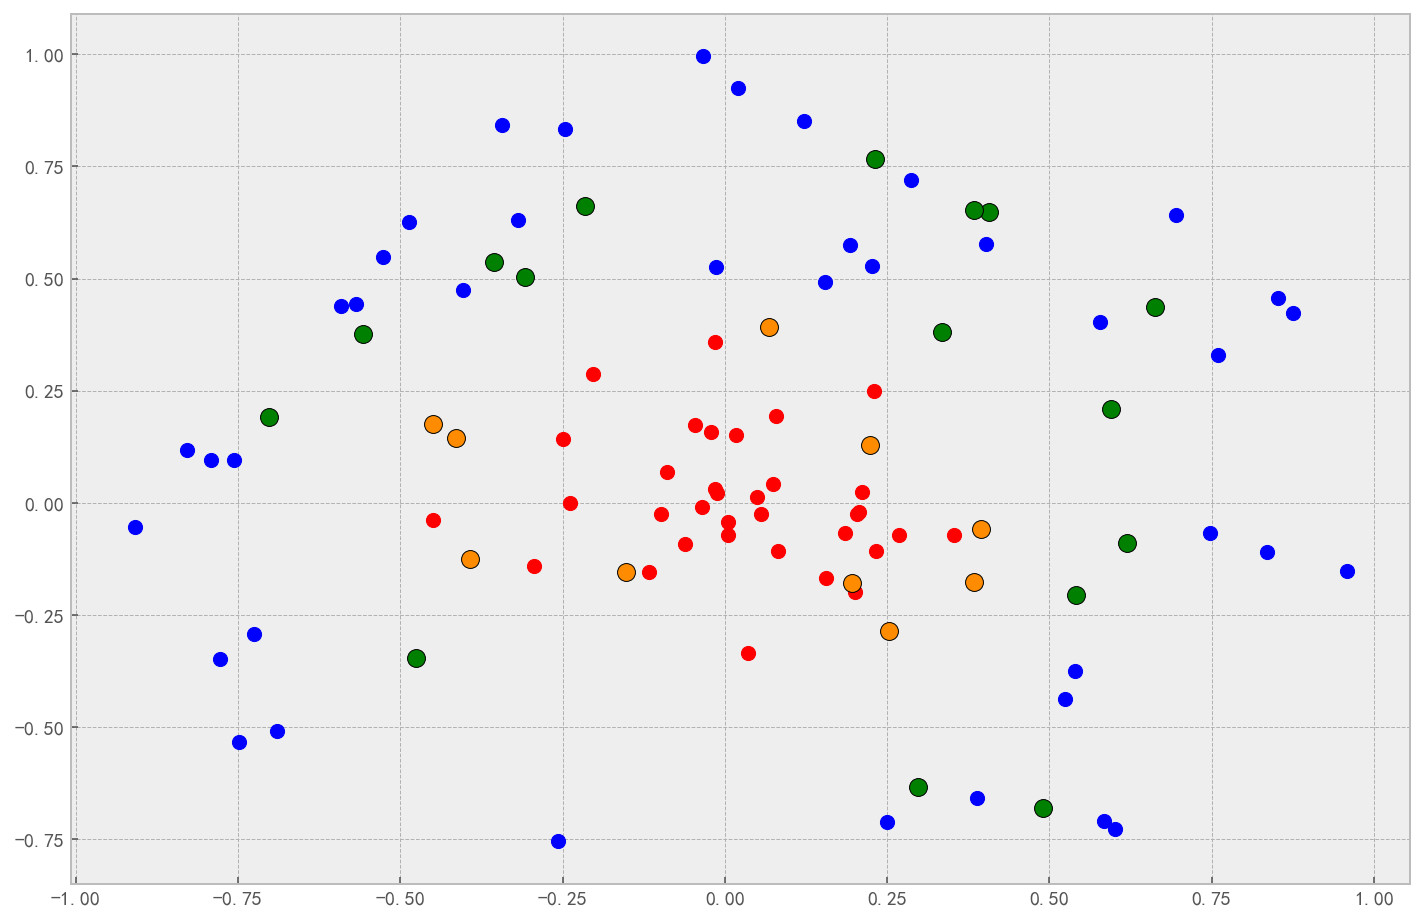

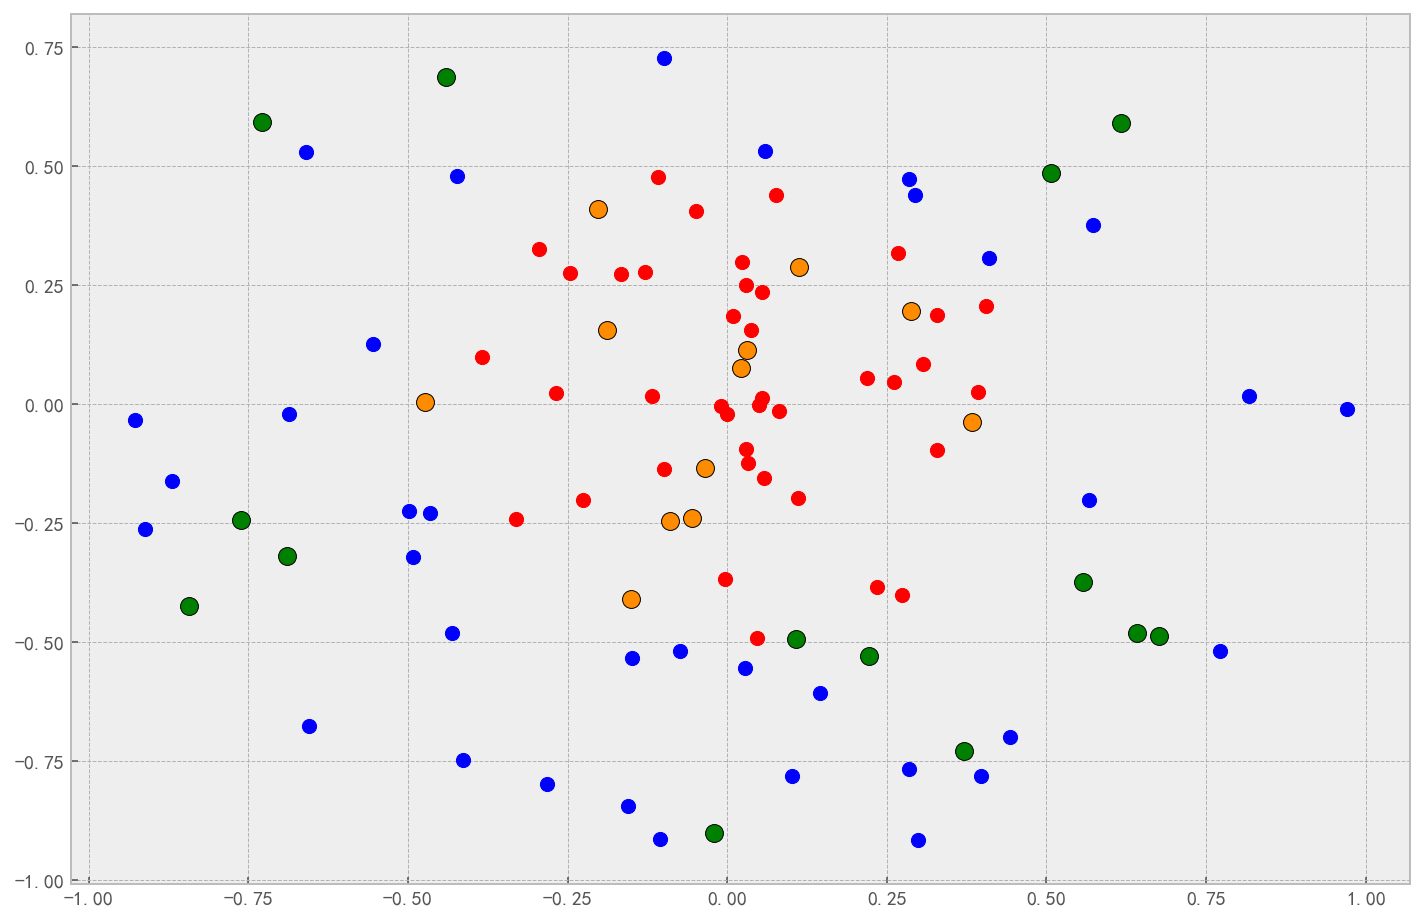

In [130]:
plotBestFit(svInd,"testSetRBF.txt")
plotBestFit(svInd2,"testSetRBF2.txt")

### 利用testRBF( )函数测试模型，可以看到，
- 径向基函数的到达率(k1)有一个最优值
    - k1越大，支持向量对分离超平面影响越大，支持向量点可能越少，容易引起欠拟合，决策边界很差
    - k1越小，支持向量对分离超平面影响越小，支持向量点可能越多，容易引起过拟合(极端-所有样本点都是支持向量>>KNN)
- 支持向量在图中看起来很杂乱，但是是正常的，因为支持向量是分离超平面两侧的样本点